In [ ]:
# Preliminaries (see the original notebook for explanations)

In [1]:
import secrets
%config InlineBackend.figure_format = 'svg'

class Transaction:
    def __init__(self, gas_premium, fee_cap, gas_used):
        self.gas_premium = gas_premium
        self.fee_cap = fee_cap
        self.gas_used = gas_used
        self.tx_hash = secrets.token_bytes(8)
        
    def __lt__(self, other):
        return self.gas_premium < other.gas_premium

Second, we'll grab a few constants from the EIP, possibly looking to change them later on.

In [2]:
constants = {
    "BASEFEE_MAX_CHANGE_DENOMINATOR": 8,
    "TARGET_GAS_USED": 12500000,
    "MAX_GAS_EIP1559": 25000000,
    "INITIAL_BASEFEE": 1 * (10 ** 9),
}

In [3]:
initial_state = {
    "basefee": constants["INITIAL_BASEFEE"],
    "demand": {}
}

In [4]:
import pandas as pd
from radcad import Model, Simulation, Experiment
from radcad.engine import Engine, Backend


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [6]:
import numpy as np
rng = np.random.default_rng(42)

def update_demand_variable(params, substep, state_history, previous_state, policy_input):
    demand = {}
    
    for i in range(100):
        gas_premium = rng.choice(list(range(1,11))) * (10 ** 9)
        fee_cap = gas_premium + rng.choice(list(range(1,11))) * (10 ** 9)
        tx = Transaction(
            gas_premium = gas_premium,
            gas_used = 21000,
            fee_cap = fee_cap
        )
        demand[tx.tx_hash] = tx
        
    return ("demand", demand)

In [7]:
class Block():
    def __init__(self, txs, flashbots):
        self.txs = txs
        self.flashbots = flashbots

In [8]:
def is_valid(tx, basefee):
    return tx.fee_cap >= basefee

In [20]:
def include_valid_txs(params, substep, state_history, previous_state):
    demand = previous_state["demand"]
    basefee = previous_state["basefee"]
    miner_gains = 0
    txs_included = []
    
    for tx_hash, tx in demand.items():
        if not is_valid(tx, basefee):
            continue
            
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        miner_gains += (gas_price - basefee) * tx.gas_used
        txs_included += [tx]
        
    assert miner_gains >= 0
    return { "block": Block(txs = txs_included, flashbots = False) }

This means we need to change our last state update.

In [21]:
def update_basefee(params, substep, state_history, previous_state, policy_input):
    block = policy_input["block"]
    basefee = previous_state["basefee"]
    
    gas_used = sum([tx.gas_used for tx in block.txs])
    delta = gas_used - constants["TARGET_GAS_USED"]
    new_basefee = basefee + basefee * delta // constants["TARGET_GAS_USED"] // constants["BASEFEE_MAX_CHANGE_DENOMINATOR"]
    
    return ("basefee", new_basefee)

We'll also record the latest block in the state.

In [22]:
def record_latest_block(params, substep, state_history, previous_state, policy_input):
    block = policy_input["block"]
    
    return ("latest_block", block)

### Bottomless pit

When a full block is produced, transactions that were not included do not suddenly disappear. Instead, the mempool fills up with unincluded transactions. It is time to add a bit of memory to our leaky mempool.

Now we might want to be a bit careful since two things can happen:

- **All transactions are included always.** That's not very interesting. We would like to observe the effects over time of congestion, so we should once in a while have a greater demand than we have supply.
- **New transactions always exceed supply.** That's no good either, and our model would quickly blow up. Unless we introduce some kind of staling, our mempool would soon be overloaded.

We try to settle for some middle ground, where in some steps we have more transactions coming in than a block can fit, and in others the demand is not too consequential, allowing blocks to catch up with older transactions.

We'll keep again transactions at a fixed size of 21,000 gas, but will introduce a new object to our simulation, the _scenario_. It is a simple array that contains at index $t$ the number of transactions coming in at time $t$ of our simulation. Since we are aiming for a block size of 12.5M gas, and we have seen that we can fit 1190 transactions asking for 21,000 gas in one block, the values in our scenario will oscillate around 1190 --- sometimes more, sometimes less.

<AxesSubplot:>

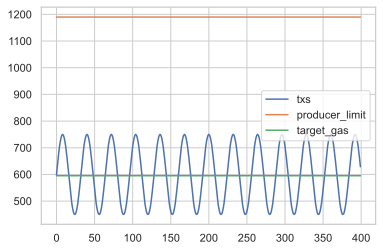

In [23]:
from math import sin, pi

timesteps = 400

def generate_oscillating_scenario(timesteps):
    return [int(600 + 150 * sin(i * pi / 16.0)) for i in range(timesteps)]

tx_scenario = generate_oscillating_scenario(timesteps)
pd.DataFrame({ "txs": tx_scenario, "producer_limit": 1190, "target_gas": 595 }).plot()

We create our state update and policy functions.

In [24]:
def update_demand_variable(params, substep, state_history, previous_state, policy_input):
    tx_scenario = params["tx_scenario"]
    demand = {}
    
    for i in range(tx_scenario[previous_state["timestep"]]):
        #gas_premium = rng.uniform(low=1, high=11) * (10 ** 9)
        #fee_cap = gas_premium + rng.uniform(low=10, high=11) * (10 ** 9)
        gas_premium = rng.uniform(low=4, high=5) * (10 ** 9)
        fee_cap = gas_premium + rng.uniform(low=1, high=2) * (10 ** 9)
        tx = Transaction(
            gas_premium = gas_premium,
            gas_used = 21000,
            fee_cap = fee_cap
        )
        demand[tx.tx_hash] = tx
        
    return ("demand", demand)

In [25]:
def remove_included_txs(params, substep, state_history, previous_state, policy_input):
    latest_block = policy_input["block"]
    demand = previous_state["demand"]
    
    for tx in latest_block.txs:
        del(demand[tx.tx_hash])
        
    return ("demand", demand)

def record_demand_size(params, substep, state_history, previous_state, policy_input):
    demand = previous_state["demand"]
    return ("demand_size", len(demand))

In [26]:
psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable,
    }
}, {
    "policies": {
        "action": include_valid_txs,
    },
    "variables": {
        "basefee": update_basefee,
        "latest_block": record_latest_block,
        "demand": remove_included_txs,
        "demand_size": record_demand_size,
    }
}]

initial_state = {
    "basefee": 5 * (10 ** 9),
    "demand": {},
    "latest_block": Block(txs=[], flashbots=False),
    "demand_size": 0,
}

blocks = 400

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
    params={ "tx_scenario": [tx_scenario] }
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df = pd.DataFrame(result)

<AxesSubplot:xlabel='timestep'>

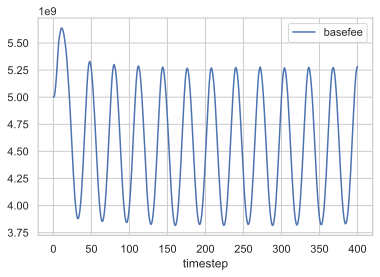

In [27]:
df.plot("timestep", "basefee")

<AxesSubplot:xlabel='timestep'>

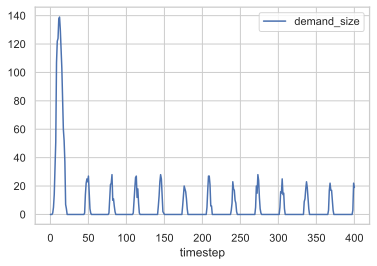

In [28]:
df.plot("timestep", "demand_size")

<AxesSubplot:xlabel='timestep'>

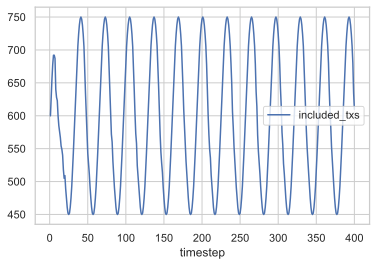

In [29]:
df["included_txs"] = df.latest_block.apply(
    lambda block: len(block.txs)
)
df[df.timestep > 0].plot("timestep", "included_txs")

In [30]:
# Need to traverse the DataFrame by rows
for i in range(df.shape[0]):
    gains = 0
    basefee = df.iloc[i].basefee
    for tx in df.iloc[i].latest_block.txs:
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        gains += (gas_price - basefee) * tx.gas_used
    df.loc[df.index[i], 'miner_gains'] = gains

<AxesSubplot:ylabel='miner_gains'>

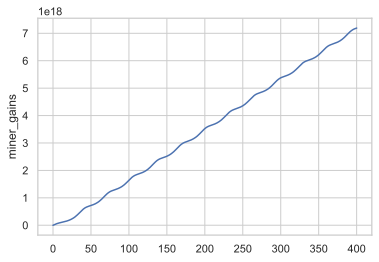

In [31]:
sns.lineplot(data = df['miner_gains'].cumsum())

## Flashbots Collusion

Here, we explore a potential collusion of miners to drive the basefee down via Flashbots. The question we ask is whether Flashbots could help this collusion by pushing miners a client that instead of adding all txs paying more than BASEFEE, fills the block up to TARGET_GAS_USED*(1-epsilon), choosing epsilon such that it leads to a 0 BASEFEE.

We'll use here the *Bottomless Pit* scenario, since it doesn't converge to a 0 BASEFEE in the standard setting as shown above. 

In [32]:
tx_scenario = generate_oscillating_scenario(timesteps)

We change the inclusion function to pick either the standard include all function, or the Flashbots collusion one, with probability p_fb, representing Flashbots fraction of Ethereum hashrate.

In [33]:
p_fb = 0.85

We modify the tx inclusion fucntion to branch according to p_fb: for regular blocks, we include all 1191 txs as before. For the flashbots blocks, we compute the number of txs included depending on the epsilon value. 

In [34]:
def include_txs_collusion(params, substep, state_history, previous_state):
    demand = previous_state["demand"]
    basefee = previous_state["basefee"]
    timestep = previous_state["timestep"]
    
    sorted_valid_demand = sorted(
        [tx for tx_hash, tx in demand.items() if is_valid(tx, basefee)],
        key = lambda tx: -tx.gas_premium
    )
    
    fb_tx_amount = int(constants['TARGET_GAS_USED']*(1-params["epsilon"])//21000)
    
    if(rng.binomial(1, p_fb)):
        included_transactions = sorted_valid_demand[0:fb_tx_amount]
        flashbots = True
    else:
        included_transactions = sorted_valid_demand[0:1190]
        flashbots = False
    
    return { "block": Block(txs = included_transactions, flashbots = flashbots) }

In [35]:
psub = [{
    "policies": {},
    "variables": {
        "demand": update_demand_variable,
    }
}, {
    "policies": {
        "action": include_txs_collusion,
    },
    "variables": {
        "basefee": update_basefee,
        "latest_block": record_latest_block,
        "demand": remove_included_txs,
        "demand_size": record_demand_size,
    }
}]

initial_state = {
    "basefee": 5 * (10 ** 9),
    "demand": {},
    "latest_block": Block(txs=[], flashbots=False),
    "demand_size": 0,
}

blocks = 400

model = Model(
    initial_state=initial_state,
    state_update_blocks=psub,
    params={ "tx_scenario": [tx_scenario], "epsilon": [0, 0.15, 0.3] }
)
simulation = Simulation(model=model, timesteps=blocks, runs=1)
experiment = Experiment([simulation])
experiment.engine = Engine(deepcopy=False, drop_substeps=True)
result = experiment.run()
df_fb = pd.DataFrame(result)

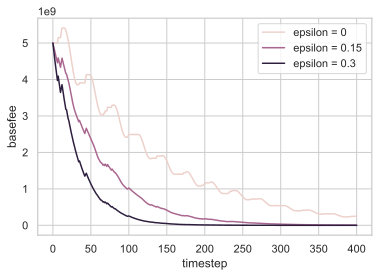

In [36]:
sns.lineplot(data=df_fb, x="timestep", y="basefee", hue="subset")
plt.legend(labels=['epsilon = 0', 'epsilon = 0.15', 'epsilon = 0.3'])

<AxesSubplot:xlabel='timestep'>

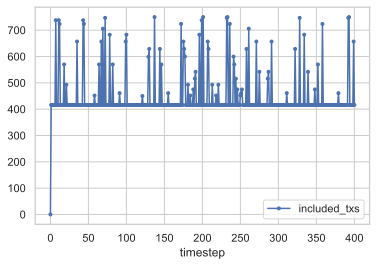

In [37]:
df_fb["included_txs"] = df_fb.latest_block.apply(
    lambda block: len(block.txs)
)
# df_fb[1:200].plot("timestep", "included_txs", style= '.-')
df_fb[802:].plot("timestep", "included_txs", style= '.-')


<AxesSubplot:xlabel='timestep'>

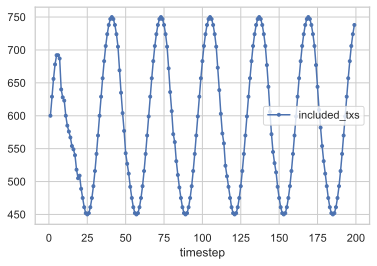

In [38]:
#df["included_txs"] = df.latest_block.apply(
#    lambda block: len(block.txs)
#)
df[1:200].plot("timestep", "included_txs", style= '.-')

Compare basefee with vanilla (different from epsilon == 0!)

In [39]:
df_comp_basefee = pd.concat([df.basefee, df_fb[df_fb.subset==0]['basefee'], \
                             df_fb[df_fb.subset==1]['basefee'].reset_index(drop=True), \
                             df_fb[df_fb.subset==2]['basefee'].reset_index(drop=True)], \
                             axis=1, keys=['standard','epsilon0','epsilon1','epsilon2'])

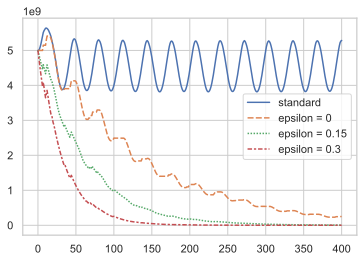

In [40]:
sns.lineplot(data=df_comp_basefee)
plt.legend(labels=['standard', 'epsilon = 0', 'epsilon = 0.15', 'epsilon = 0.3'])

Compute miner gains

In [41]:
# Need to traverse the DataFrame by rows
for i in range(df_fb.shape[0]):
    gains = 0
    basefee = df_fb.iloc[i].basefee
    for tx in df_fb.iloc[i].latest_block.txs:
        gas_price = min([basefee + tx.gas_premium, tx.fee_cap])
        gains += (gas_price - basefee) * tx.gas_used
    df_fb.loc[df_fb.index[i], 'miner_gains'] = gains
    df_fb.loc[df_fb.index[i], 'flashbots'] = df_fb.iloc[i].latest_block.flashbots

Compute cumulative gains

In [42]:
df_fb['cum_gains']=pd.concat([df_fb[df_fb.subset==0]['miner_gains'].cumsum(), df_fb[df_fb.subset==1]['miner_gains'].cumsum(), \
                              df_fb[df_fb.subset==2]['miner_gains'].cumsum()])

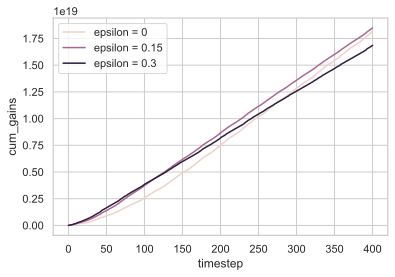

In [43]:
sns.lineplot(data = df_fb, x="timestep", y="cum_gains", hue="subset")
plt.legend(labels=['epsilon = 0', 'epsilon = 0.15', 'epsilon = 0.3'])

Compare miner gains with vanilla, take last value of epsilon (vanilla is different from epsilon == 0!)

In [44]:
df_comp_gains = pd.concat([df['miner_gains'], df_fb[df_fb.subset==2]['miner_gains'].reset_index(drop=True), \
                           df['miner_gains'].cumsum(), \
                           df_fb[df_fb.subset==2]['cum_gains'].reset_index(drop=True), \
                           df_fb[df_fb.subset==2]['flashbots'].reset_index(drop=True)], \
                           axis=1, keys=['gain_standard', 'gain_epsilon', 'cum_standard', 'cum_epsilon', 'flashbots'])

In [45]:
df_comp_gains[df_comp_gains['flashbots']==True]

,gain_standard,gain_epsilon,cum_standard,cum_epsilon,flashbots
1,1.253950e+16,1.183287e+16,1.253950e+16,1.183287e+16,True
2,1.262767e+16,1.340130e+16,2.516718e+16,2.523417e+16,True
3,1.235936e+16,1.518336e+16,3.752654e+16,4.041753e+16,True
4,1.109890e+16,1.633046e+16,4.862544e+16,5.674799e+16,True
5,1.015954e+16,1.789883e+16,5.878498e+16,7.464682e+16,True
...,...,...,...,...,...
395,1.732366e+16,4.128551e+16,7.132045e+18,1.662381e+19,True
396,1.507788e+16,4.128374e+16,7.147122e+18,1.666509e+19,True
397,1.267303e+16,4.101797e+16,7.159796e+18,1.670611e+19,True
398,1.115757e+16,4.089953e+16,7.170953e+18,1.674701e+19,True


<AxesSubplot:>

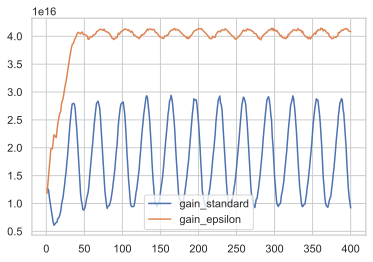

In [46]:
df_comp_gains[df_comp_gains['flashbots']==True].plot(y=['gain_standard','gain_epsilon'])

<AxesSubplot:>

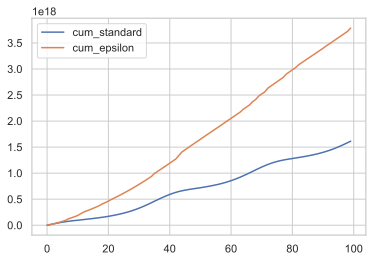

In [47]:
# sns.lineplot(data=df_comp_gains, y=['epsilon0', 'standard'])
df_comp_gains[0:100].plot(y=['cum_standard','cum_epsilon'])
# plt.legend(labels=['standard', 'epsilon = 0'])#, 'epsilon = 0.15', 'epsilon = 0.3'])

<AxesSubplot:>

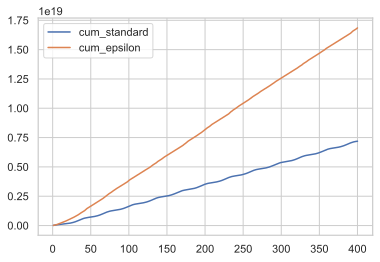

In [48]:
df_comp_gains[df_comp_gains['flashbots']==True].plot(y=['cum_standard','cum_epsilon']) # WRONG, cumsums including ALL

<AxesSubplot:>

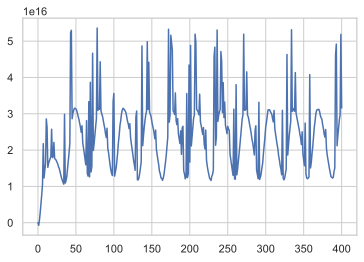

In [49]:
sns.lineplot(data=df_comp_gains['gain_epsilon']-df_comp_gains['gain_standard'])

<AxesSubplot:>

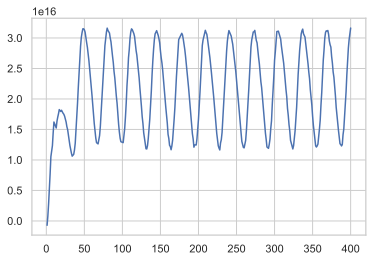

In [50]:
sns.lineplot(data=df_comp_gains[df_comp_gains['flashbots']==True]['gain_epsilon']-df_comp_gains[df_comp_gains['flashbots']==True]['gain_standard'])

Final step: miner "roulette": the previous shows the total gains, but we need to take into consideration the perspective of a single miner with a share of x of the total hashrate. They will clearly be benefited if they don't land in the first few blocks, but what if they do? How long will it take them to compensate their loss?

Worst case: take the miner with the maximum negative difference between the policies, and see how many blocks it'd take them to compensate. But it all depends extremely sensitively with demand (see parameters for tip and cap)--so cannot derive any meaningful conclusions.